# Generación del Laberinto

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import numpy as np
import math
from matplotlib import collections  as mc
import pylab as pl

In [2]:
class Obstacle:
  pos = ''
  width = ''
  height = ''

  def __init__(self, p, w, h):
    self.pos = p
    self.width = w
    self.height = h


In [3]:
liminf_X = 0
limsup_X = 8
liminf_Y = 0
limsup_Y = 8

In [4]:
obstacles = []
wt = 0.25/2

#Paredes del laberinto
obstacles.append(Obstacle((2-wt,0), 0.25, 2 + wt))
obstacles.append(Obstacle((2+wt, 2-wt), 2, 0.25))

obstacles.append(Obstacle((0, 4-wt), 4-wt, 0.25))
obstacles.append(Obstacle((4-wt, 4-wt), 0.25, 2 + 2*wt))
obstacles.append(Obstacle((2-wt, 6-wt), 2, 0.25))

obstacles.append(Obstacle((6-wt, 6-wt), 0.25, 2 + 2*wt))

obstacles.append(Obstacle((6-wt, 2-wt), 0.25, 2 + 2*wt))
obstacles.append(Obstacle((6+wt, 4-wt), 2-wt, 0.25))

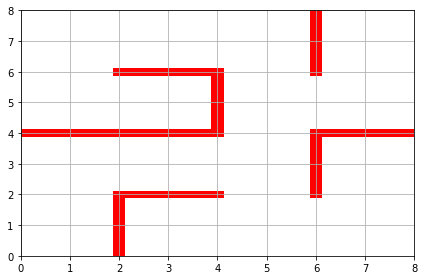

In [5]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

plt.grid()
plt.tight_layout()
plt.show()

# Primitive Functions

## Colisiones de puntos

In [7]:
# CIRCLE/RECTANGLE
def circleRect(cx,cy,radius, rx, ry, rw, rh):

  # temporary variables to set edges for testing
  testX = cx;
  testY = cy;

  # which edge is closest?
  if (cx < rx):
    testX = rx      # test left edge
  elif (cx > rx+rw):
    testX = rx+rw   # right edge
  if (cy < ry):
    testY = ry      # top edge
  elif (cy > ry+rh):
    testY = ry+rh   # bottom edge

  # get distance from closest edges
  distX = cx-testX
  distY = cy-testY
  distance = np.sqrt((distX*distX) + (distY*distY))

  # if the distance is less than the radius, collision!
  if (distance <= radius):
    return True

  return False

def sampleFree(x,y,r):
  for rec in obstacles:
    rx = rec.pos[0]
    ry = rec.pos[1]
    rw = rec.width
    rh = rec.height

    if circleRect(x,y,r, rx, ry, rw, rh) == True:
      return False

  return True

## Colisiones de aristas

In [8]:
def collisionFree(x1, y1, x2, y2, r):
  for rec in obstacles:
    #Parametros del obstaculo (rectangulo)
    rx = rec.pos[0]
    ry = rec.pos[1]
    rw = rec.width
    rh = rec.height

    numSamples = 10

    for i in range(numSamples+1):
      xm = (x2-x1)*(i/numSamples)+x1
      ym = (y2-y1)*(i/numSamples)+y1
      #Si un circulo de la muestra no es libre de colision,
      #regresamos que la trayectoria no es posible
      if sampleFree(xm,ym,r) == False:
        return False


  return True

## Near Function

In [9]:
def Near(V, x, y, r):
  B = []

  for v in V:
    v = np.array(v)
    u = np.array([x, y])
    if np.linalg.norm(u - v) < r:
      B.append(v)
  return B

## Nearest Function

In [10]:
def Nearest(V,x,y):
  vmin=np.array([np.inf,np.inf])
  for v in V:
    v = np.array(v)
    u = np.array([x, y])
    if np.linalg.norm(u - v) < np.linalg.norm(vmin- u):
      vmin=v

  return vmin

## Steer Function

In [11]:
def Steer(x1,y1,x2,y2,eta):
  u = np.array([x1,y1])
  v = np.array([x2,y2])

  p = (u-v)/np.linalg.norm(u-v)
  return u + eta*p

# PRM*

In [12]:
#Primero declaramos una función para crear un conjunto de puntos dentro del WORLD que sean sample free
#El parametro n corresponde al numero de muestras con las que el usuario quiere trabajar
#r corresponde al radio del robot con el que trabajamos

def CreateSampleSet(n, r):

  #Inicializamos un array
  Set = []

  while True:

    new_point = np.random.uniform(low = 0.25, high = 7.75, size = 2)

    if sampleFree(new_point[0], new_point[1], r) == True:
      Set.append([new_point[0], new_point[1]])

    if len(Set) == n:
      break

  return Set


In [13]:
#Regresa al area de X_free
def mu():
  X = limsup_X * limsup_Y

  for rec in obstacles:
    X -= rec.width * rec.height

  print(X)
  return X



In [14]:
def y_prm(r):
  mu_prm = mu()
  y_PRM = 2* math.pow((1 + 1/2), 1/2) * math.pow((mu_prm/(math.pi*(1))), 1/2)

  return y_PRM

In [15]:
def PRM_STAR(x_init, n , r):

  #Inicializamos los elementos del grafo G = (V, E)
  #V corresponde a el arreglo de vertices
  #E corresponde a el arrglo de aristas

  V = []
  E = []


  #Ahora, V lo inicializamos con el punto inicial y un numero de muestras sample free

  V.append(x_init)
  SF = CreateSampleSet(n, r)

  V = V + SF

  Vecinos  = []

  for i in range(len(V)):
    Vecinos.append([])


  radius_near = y_prm(r)* math.pow((math.log(n)/n), 1/2) +1
  print(radius_near)


  for v in V:

    Vcopy = V.copy()
    Vcopy.remove(v)

    U = Near(Vcopy, v[0], v[1], radius_near)

    for u in U:

      if (collisionFree(v[0], v[1], u[0], u[1], r) == True):
        E.append([v, [u[0], u[1]]])

        #Agregamos a los vecinos
        v_id = np.where((np.array(V) == np.array(v)).all(axis=1))[0][0]
        u_id = np.where((np.array(V) == u).all(axis=1))[0][0]

        Vecinos[v_id].append(u_id)
        Vecinos[u_id].append(v_id)

  return V, E, Vecinos


In [16]:
def Regionmeta(x,i, radio_robot):

  if(2*(i%4)+radio_robot<=x[0] and x[0]<= 2*(i%4 +1)-radio_robot):
    if (2*(int(i/4)%5)+radio_robot<=x[1] and x[1]<=2*((int(i/4)+1)%5)-radio_robot):
      return True

  return False

In [17]:
import numpy as np
import math
import random

def distancia_euclidiana(punto1, punto2):
    return np.linalg.norm(punto2 - punto1)

def dijkstra(V, E, Vecinos, inicio, celda, radio):
    V=np.array(V)
    #Distancias
    distancias = []
    for v in V:
      distancias.append(np.inf)
    #print("D:",distancias)
    id = np.where((V == inicio).all(axis=1))[0][0]
   
    distancias[id] = 0

    #Visitados
    visitados = []
    for v in V:
      visitados.append(False)

    #Padres
    padres = {tuple(punto): None for punto in V}

    #Vecinos [Parte pesada]
    #Vecinos= [[]]
    #cof=0
    #for v in V:
    #  if(cof % 50 == 0):
    #    print(cof)
    #  cof+=1
    #  v_id = np.where((V == v).all(axis=1))[0][0]
    #  Vecinos.append([])
    #  for arista in E:
    #    punto1, punto2 = arista
    #    if np.array_equal(punto1, v):
    #            vv_id = np.where((V == punto2).all(axis=1))[0][0]
    #            #print("v:",v_id)
    #            Vecinos[v_id].append(vv_id)


    Q = set()
    i=0
    for v in V:
      Q.add(i)
      i+=1


    #while any(not visitado for visitado in visitados.values()):
    while( len(Q)) :
        #print("Q:",len(Q))
        #Minima distancia en Q
        actual_id= random.choice(tuple(Q))
        for q in Q:
            if distancias[q]<distancias[actual_id] :
              actual_id = q
        visitados[actual_id] = True

        if distancias[actual_id] == np.infty:
          break

        #if actual_id == np.where((V == fin).all(axis=1))[0][0]:
         #   break
        
        if Regionmeta(V[actual_id], celda, radio):
           break

        Q.remove(actual_id)

        for v in Vecinos[actual_id]:
            distancia = distancias[actual_id] + distancia_euclidiana(V[actual_id], V[v])
            #print("dist:",distancia, "dists:",distancias[v], "v:",v)
            if distancia < distancias[v]:
              distancias[v] = distancia
              padres[tuple(V[v])] = tuple(V[actual_id])
    
    fin = V[actual_id]
    if padres[tuple(fin)] is None:
        return None, np.inf  # No hay camino hasta el punto final

    # Construir el camino óptimo
    camino = [fin]
    actual = tuple(fin)
    while actual != tuple(inicio):
        actual = padres[actual]
        camino.append(actual)
    camino.reverse()

    return camino, distancias[np.where((V == fin).all(axis=1))[0][0]]


In [18]:
def optimalPath(V,E, Vecinos, inicio, celda, radio):
  print(inicio)
  inicio=Nearest(V,inicio[0],inicio[1])
  
  camino_optimo, distancia_recorrida = dijkstra(V, E, Vecinos, inicio, celda, radio)
  if camino_optimo is None:
      print("No hay camino desde el punto de inicio al punto final.")
  else:
      print("Camino óptimo:", camino_optimo)
     

  return camino_optimo

# Pruebas Finales

## Generación de Puntos Aleatorios

Leemos los puntos aleatorios

In [19]:
with open('initialPoints.txt') as f:
    array = []
    for line in f:
        array.append([float(x) for x in line.split()])

In [20]:
Cuadrante_1  = []
Cuadrante_2  = []
Cuadrante_3  = []
Cuadrante_4  = []
Cuadrante_5  = []
Cuadrante_6  = []
Cuadrante_7  = []
Cuadrante_8  = []
Cuadrante_9  = []
Cuadrante_10  = []
Cuadrante_11  = []
Cuadrante_12  = []
Cuadrante_13  = []
Cuadrante_14  = []
Cuadrante_15  = []
Cuadrante_16  = []

In [21]:
for i in range(len(array)):
    if i < 10:
        Cuadrante_1.append(array[i])
    elif i >= 10 and i < 20:
        Cuadrante_2.append(array[i])
    elif i >= 20 and i < 30:
        Cuadrante_3.append(array[i])
    elif i >= 30 and i < 40:
        Cuadrante_4.append(array[i])
    elif i >= 40 and i < 50:
        Cuadrante_5.append(array[i]) 
    elif i >= 50 and i < 60:
        Cuadrante_6.append(array[i])
    elif i >= 60 and i < 70:
        Cuadrante_7.append(array[i])
    elif i >= 70 and i < 80:
        Cuadrante_8.append(array[i])
    elif i >= 80 and i < 90:
        Cuadrante_9.append(array[i])
    elif i >= 90 and i < 100:
        Cuadrante_10.append(array[i])
    elif i >= 100 and i < 110:
        Cuadrante_11.append(array[i])
    elif i >= 110 and i < 120:
        Cuadrante_12.append(array[i])
    elif i >= 120 and i < 130:
        Cuadrante_13.append(array[i])
    elif i >= 130 and i < 140:
        Cuadrante_14.append(array[i])  
    elif i >= 140 and i < 150:
        Cuadrante_15.append(array[i])   
    elif i >= 150 and i < 160:
        Cuadrante_16.append(array[i])

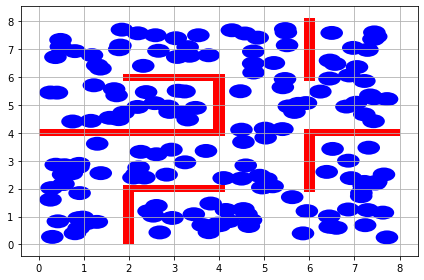

In [22]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for i in range(len(array)):
  circle_patch = Circle((array[i][0],array[i][1]), .25, facecolor='blue')
  ax.add_patch(circle_patch)

ax.autoscale()

plt.grid()
plt.tight_layout()
plt.show()

In [23]:
def PRM_STAR(n , r):

  #Inicializamos los elementos del grafo G = (V, E)
  #V corresponde a el arreglo de vertices
  #E corresponde a el arrglo de aristas

  V = []
  E = []


  #Ahora, V lo inicializamos con el punto inicial y un numero de muestras sample free
  SF = CreateSampleSet(n, r)

  V = V + array

  V = V + SF

  Vecinos  = []

  for i in range(len(V)):
    Vecinos.append([])


  radius_near = y_prm(r)* math.pow((math.log(n)/n), 1/2) +1
  print(radius_near)


  for v in V:

    Vcopy = V.copy()
    Vcopy.remove(v)

    U = Near(Vcopy, v[0], v[1], radius_near)

    for u in U:

      if (collisionFree(v[0], v[1], u[0], u[1], r) == True):
        E.append([v, [u[0], u[1]]])

        #Agregamos a los vecinos
        v_id = np.where((np.array(V) == np.array(v)).all(axis=1))[0][0]
        u_id = np.where((np.array(V) == u).all(axis=1))[0][0]

        Vecinos[v_id].append(u_id)
        Vecinos[u_id].append(v_id)

  return V, E, Vecinos


In [76]:
V, E, Vecinos = PRM_STAR(840, .25)

59.34375
1.9531599972812557


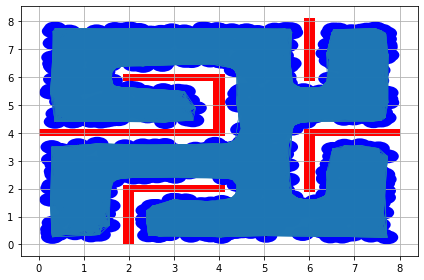

In [77]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for i in range(len(V)):
  circle_patch = Circle((V[i][0],V[i][1]), .25, facecolor='blue')
  ax.add_patch(circle_patch)



lc = mc.LineCollection(E, linewidths=.5)
ax.add_collection(lc)

ax.autoscale()

plt.grid()
plt.tight_layout()
plt.show()

# Escribir caminos en txt

In [68]:
# Generar listas de tuplas de puntos
lista1 = [(1, 2.488494293294324923492504), (3, 4), (5, 6)]
lista2 = [(7, 8), (9, 10), (11, 12)]
lista3 = [(13, 14), (15, 16), (17, 18)]

# Nombre del archivo
nombre_archivo = 'puntos.txt'

# Escribir las listas en el archivo de texto
with open(nombre_archivo, 'w') as archivo:
    for punto in lista1:
        archivo.write(f'{punto[0]},{punto[1]}\n')
    archivo.write('\n')  # Separación entre las listas

    for punto in lista2:
        archivo.write(f'{punto[0]},{punto[1]}\n')
    archivo.write('\n')  # Separación entre las listas

    for punto in lista3:
        archivo.write(f'{punto[0]},{punto[1]}\n')
    archivo.write('\n')  # Separación entre las listas

# Leer las listas desde el archivo de texto
listas_leidas = []
lista_temporal = []

with open(nombre_archivo, 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)



Lista 1 leída: [(1.0, 2.488494293294325), (3.0, 4.0), (5.0, 6.0)]
Lista 2 leída: [(7.0, 8.0), (9.0, 10.0), (11.0, 12.0)]
Lista 3 leída: [(13.0, 14.0), (15.0, 16.0), (17.0, 18.0)]


### Puntos centrales 

In [ ]:
puntos_objetivo = [[1, 1], [3, 1], [5, 1],[7, 1], [1, 3], [3, 3], [5, 3], [7, 3], [5, 1], [5, 3], []]

## Celda 1

In [90]:

with open('Celda1.txt', 'w') as archivo:

    for i in range(len(Cuadrante_1)):
        punto = Cuadrante_1[i]

        for j in range(16):
            if j != 0:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[1.05235289 0.75849379]
Camino óptimo: [(1.0523528875907853, 0.7584937909327754), (1.6529769159825145, 2.277842715066814), (1.889706112801862, 2.4629089009917706), (2.9323626952623605, 2.4698931587840667), (4.218952465947217, 2.489614596965562), (4.4194347363063375, 2.128362243656859), (4.3590128762896745, 1.4287859209016591), array([3.62032397, 1.38004053])]
[1.05235289 0.75849379]
Camino óptimo: [(1.0523528875907853, 0.7584937909327754), (1.6529769159825145, 2.277842715066814), (1.889706112801862, 2.4629089009917706), (2.9323626952623605, 2.4698931587840667), (4.218952465947217, 2.489614596965562), array([4.70097599, 1.73016537])]
[1.05235289 0.75849379]
Camino óptimo: [(1.0523528875907853, 0.7584937909327754), (1.6529769159825145, 2.277842715066814), (1.889706112801862, 2.4629089009917706), (3.028943697109627, 2.4270735119575795), (4.499096190332891, 2.359421416458538), (5.225097258788709, 1.777788313480896), (6.134144274960276, 1.5427512506118717), array([6.48843242, 1.58212413])]


## Celda 2

In [91]:

with open('Celda2.txt', 'w') as archivo:

    for i in range(len(Cuadrante_2)):
        punto = Cuadrante_2[i]

        for j in range(16):
            if j != 1:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[3.63697645 0.69433096]
Camino óptimo: [(3.6369764502236306, 0.6943309572331877), (4.3590128762896745, 1.4287859209016591), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), (2.9323626952623605, 2.4698931587840667), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[3.63697645 0.69433096]
Camino óptimo: [(3.6369764502236306, 0.6943309572331877), array([4.37256743, 0.44801979])]
[3.63697645 0.69433096]
Camino óptimo: [(3.6369764502236306, 0.6943309572331877), (5.174251799792183, 0.5413698636571651), array([6.29483754, 0.45988963])]
[3.63697645 0.69433096]
Camino óptimo: [(3.6369764502236306, 0.6943309572331877), (4.3590128762896745, 1.4287859209016591), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), (3.0080267304597044, 2.678535987872556), array([1.72833618, 2.86960175])]
[3.63697645 0.69433096]
Camino óptimo: [(3.6369764502236306, 0.6943309572331877), (4.359

## Celda 3

In [92]:

with open('Celda3.txt', 'w') as archivo:

    for i in range(len(Cuadrante_3)):
        punto = Cuadrante_3[i]

        for j in range(16):
            if j != 2:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[4.65972839 0.66017837]
Camino óptimo: [(4.659728389317476, 0.6601783651363076), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), (2.9323626952623605, 2.4698931587840667), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[4.65972839 0.66017837]
Camino óptimo: [(4.659728389317476, 0.6601783651363076), array([3.71721643, 0.50252294])]
[4.65972839 0.66017837]
Camino óptimo: [(4.659728389317476, 0.6601783651363076), array([6.29483754, 0.45988963])]
[4.65972839 0.66017837]
Camino óptimo: [(4.659728389317476, 0.6601783651363076), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), (3.0080267304597044, 2.678535987872556), array([1.72833618, 2.86960175])]
[4.65972839 0.66017837]
Camino óptimo: [(4.659728389317476, 0.6601783651363076), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), array([3.71275872, 2.71888393])]
[4.65972839 0.66017837

## Celda 4

In [93]:

with open('Celda4.txt', 'w') as archivo:

    for i in range(len(Cuadrante_4)):
        punto = Cuadrante_4[i]

        for j in range(16):
            if j != 3:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[6.44129024 1.00408251]
Camino óptimo: [(6.441290243213739, 1.004082507316271), (4.952065798473587, 2.04126277075203), (4.499096190332891, 2.359421416458538), (3.028943697109627, 2.4270735119575795), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[6.44129024 1.00408251]
Camino óptimo: [(6.441290243213739, 1.004082507316271), (4.534978108258454, 0.8861154499068861), array([3.67900733, 0.83241283])]
[6.44129024 1.00408251]
Camino óptimo: [(6.441290243213739, 1.004082507316271), array([5.55342607, 1.01324997])]
[6.44129024 1.00408251]
Camino óptimo: [(6.441290243213739, 1.004082507316271), (4.952065798473587, 2.04126277075203), (4.499096190332891, 2.359421416458538), (3.3359350647205273, 2.582777935798468), array([1.72833618, 2.86960175])]
[6.44129024 1.00408251]
Camino óptimo: [(6.441290243213739, 1.004082507316271), (5.225097258788709, 1.777788313480896), array([3.71275872, 2.71888393])]
[6.44129024 1.00408251]
Camino ó

## Celda 5

In [94]:

with open('Celda5.txt', 'w') as archivo:

    for i in range(len(Cuadrante_5)):
        punto = Cuadrante_5[i]

        for j in range(16):
            if j != 4:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[0.54212596 2.50718181]
Camino óptimo: [(0.5421259637978773, 2.507181814200189), array([0.46319293, 1.59604688])]
[0.54212596 2.50718181]
Camino óptimo: [(0.5421259637978773, 2.507181814200189), (2.171091569222998, 2.5288760444687695), (2.836722647011098, 2.5021994484698435), (4.218952465947217, 2.489614596965562), (4.4194347363063375, 2.128362243656859), (4.3590128762896745, 1.4287859209016591), array([3.62032397, 1.38004053])]
[0.54212596 2.50718181]
Camino óptimo: [(0.5421259637978773, 2.507181814200189), (2.171091569222998, 2.5288760444687695), (2.836722647011098, 2.5021994484698435), (4.218952465947217, 2.489614596965562), array([4.70097599, 1.73016537])]
[0.54212596 2.50718181]
Camino óptimo: [(0.5421259637978773, 2.507181814200189), (1.889706112801862, 2.4629089009917706), (3.028943697109627, 2.4270735119575795), (4.499096190332891, 2.359421416458538), (5.225097258788709, 1.777788313480896), (6.134144274960276, 1.5427512506118717), array([6.48843242, 1.58212413])]
[0.54212596 2.

## Celda 6

In [95]:

with open('Celda6.txt', 'w') as archivo:

    for i in range(len(Cuadrante_6)):
        punto = Cuadrante_6[i]

        for j in range(16):
            if j != 5:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[2.17109157 2.52887604]
Camino óptimo: [(2.171091569222998, 2.5288760444687695), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[2.17109157 2.52887604]
Camino óptimo: [(2.171091569222998, 2.5288760444687695), (2.836722647011098, 2.5021994484698435), (4.218952465947217, 2.489614596965562), (4.4194347363063375, 2.128362243656859), (4.3590128762896745, 1.4287859209016591), array([3.62032397, 1.38004053])]
[2.17109157 2.52887604]
Camino óptimo: [(2.171091569222998, 2.5288760444687695), (2.836722647011098, 2.5021994484698435), (4.218952465947217, 2.489614596965562), array([4.70097599, 1.73016537])]
[2.17109157 2.52887604]
Camino óptimo: [(2.171091569222998, 2.5288760444687695), (2.9323626952623605, 2.4698931587840667), (4.499096190332891, 2.359421416458538), (5.225097258788709, 1.777788313480896), (6.134144274960276, 1.5427512506118717), array([6.48843242, 1.58212413])]
[2.17109157 2.52887604]
Camino óptimo: [(2.17109156922

## Celda 7

In [96]:

with open('Celda7.txt', 'w') as archivo:

    for i in range(len(Cuadrante_7)):
        punto = Cuadrante_7[i]

        for j in range(16):
            if j != 6:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[4.95783982 2.04276592]
Camino óptimo: [(4.957839820208189, 2.042765920733605), (4.499096190332891, 2.359421416458538), (3.028943697109627, 2.4270735119575795), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[4.95783982 2.04276592]
Camino óptimo: [(4.957839820208189, 2.042765920733605), (4.057174968786818, 1.524334989288717), array([3.62032397, 1.38004053])]
[4.95783982 2.04276592]
Camino óptimo: [(4.957839820208189, 2.042765920733605), array([4.70097599, 1.73016537])]
[4.95783982 2.04276592]
Camino óptimo: [(4.957839820208189, 2.042765920733605), (5.225097258788709, 1.777788313480896), (6.134144274960276, 1.5427512506118717), array([6.48843242, 1.58212413])]
[4.95783982 2.04276592]
Camino óptimo: [(4.957839820208189, 2.042765920733605), (4.499096190332891, 2.359421416458538), (3.3359350647205273, 2.582777935798468), array([1.72833618, 2.86960175])]
[4.95783982 2.04276592]
Camino óptimo: [(4.957839820208189, 2.04276592

## Celda 8

In [97]:

with open('Celda8.txt', 'w') as archivo:

    for i in range(len(Cuadrante_8)):
        punto = Cuadrante_8[i]

        for j in range(16):
            if j != 7:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[7.31702042 3.46743438]
Camino óptimo: [(7.317020416315542, 3.467434382184379), (6.537284908060844, 1.911777970784213), (6.134144274960276, 1.5427512506118717), (5.225097258788709, 1.777788313480896), (4.499096190332891, 2.359421416458538), (3.028943697109627, 2.4270735119575795), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[7.31702042 3.46743438]
Camino óptimo: [(7.317020416315542, 3.467434382184379), (6.537284908060844, 1.911777970784213), (6.134144274960276, 1.5427512506118717), (4.3590128762896745, 1.4287859209016591), array([3.62032397, 1.38004053])]
[7.31702042 3.46743438]
Camino óptimo: [(7.317020416315542, 3.467434382184379), (6.537284908060844, 1.911777970784213), (6.134144274960276, 1.5427512506118717), (5.820486751649518, 1.4417869086255128), array([5.6204326 , 1.69499473])]
[7.31702042 3.46743438]
Camino óptimo: [(7.317020416315542, 3.467434382184379), array([7.15004494, 1.72997967])]
[7.31702042 3.46743

## Celda 9

In [98]:

with open('Celda9.txt', 'w') as archivo:

    for i in range(len(Cuadrante_9)):
        punto = Cuadrante_9[i]

        for j in range(16):
            if j != 8:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[1.72869325 5.34566882]
Camino óptimo: [(1.7286932540919244, 5.345668823951627), (1.6160585217744134, 5.876506217384359), (1.592861161794295, 6.44893043437007), (2.743754849407916, 6.434906925357242), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.477868771956963, 5.085139985453597), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[1.72869325 5.34566882]
Camino óptimo: [(1.7286932540919244, 5.345668823951627), (1.6160585217744134, 5.876506217384359), (1.592861161794295, 6.44893043437007), (2.743754849407916, 6.434906925357242), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.65208320312902, 3.703822524810095), (4.656632481437258, 2.854985366962848), (4.274115177495981, 1.43441888122797), array

## Celda 10

In [99]:

with open('Celda10.txt', 'w') as archivo:

    for i in range(len(Cuadrante_10)):
        punto = Cuadrante_10[i]

        for j in range(16):
            if j != 9:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[3.30458499 4.47981109]
Camino óptimo: [(3.3045849855476583, 4.479811085311115), (2.903369466276035, 4.749831319414675), (1.6734425355679061, 5.564855061194839), (1.6160585217744134, 5.876506217384359), (1.592861161794295, 6.44893043437007), (2.743754849407916, 6.434906925357242), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.477868771956963, 5.085139985453597), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[3.30458499 4.47981109]
Camino óptimo: [(3.3045849855476583, 4.479811085311115), (2.903369466276035, 4.749831319414675), (1.6734425355679061, 5.564855061194839), (1.6160585217744134, 5.876506217384359), (1.592861161794295, 6.44893043437007), (2.743754849407916, 6.434906925357242), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216),

## Celda 11

In [100]:

with open('Celda11.txt', 'w') as archivo:

    for i in range(len(Cuadrante_11)):
        punto = Cuadrante_11[i]

        for j in range(16):
            if j != 10:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[5.75606732 5.03888497]
Camino óptimo: [(5.756067322449473, 5.03888497031389), (5.231512634878379, 4.540673192911674), (3.912013877084611, 3.3459611173348827), (3.0474357393077542, 2.9898802729477953), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[5.75606732 5.03888497]
Camino óptimo: [(5.756067322449473, 5.03888497031389), (5.390924508199056, 4.168335667718906), (4.832993275001271, 2.837622742325062), (4.274115177495981, 1.43441888122797), array([3.62032397, 1.38004053])]
[5.75606732 5.03888497]
Camino óptimo: [(5.756067322449473, 5.03888497031389), (5.500448252949053, 3.494983977614827), array([5.25972353, 1.71687682])]
[5.75606732 5.03888497]
Camino óptimo: [(5.756067322449473, 5.03888497031389), (5.622313359455259, 4.151616021900779), (5.541250398299255, 2.3248392592008535), (5.620432597462387, 1.6949947269660637), array([6.48802028, 1.33094338])]
[5.75606732 5.03888497]
Camino óptimo: [(5.756067322449473, 5.0388

## Celda 12

In [101]:

with open('Celda12.txt', 'w') as archivo:

    for i in range(len(Cuadrante_12)):
        punto = Cuadrante_12[i]

        for j in range(16):
            if j != 11:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[7.21898175 4.66324094]
Camino óptimo: [(7.218981746253269, 4.663240944513187), (5.441370895761588, 4.293151776835348), (4.012908045335268, 3.4976230751349986), (3.3496860837957914, 3.1591278701930943), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[7.21898175 4.66324094]
Camino óptimo: [(7.218981746253269, 4.663240944513187), (6.1017830010867105, 4.5811689466849534), (5.527313332975228, 4.192385091665816), (4.8647450272366015, 2.7924289490157443), (4.274115177495981, 1.43441888122797), array([3.62032397, 1.38004053])]
[7.21898175 4.66324094]
Camino óptimo: [(7.218981746253269, 4.663240944513187), (6.1017830010867105, 4.5811689466849534), (5.527313332975228, 4.192385091665816), (5.411686783875657, 3.232766593610616), array([5.25972353, 1.71687682])]
[7.21898175 4.66324094]
Camino óptimo: [(7.218981746253269, 4.663240944513187), (6.1017830010867105, 4.5811689466849534), (5.527313332975228, 4.192385091665816), (5.526037

## Celda 13

In [102]:

with open('Celda13.txt', 'w') as archivo:

    for i in range(len(Cuadrante_13)):
        punto = Cuadrante_13[i]

        for j in range(16):
            if j != 12:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[1.18336092 6.78281129]
Camino óptimo: [(1.1833609150815065, 6.782811289558579), (2.20712846692967, 6.6950172361997335), (3.3947145724443653, 6.572383764460879), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.477868771956963, 5.085139985453597), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[1.18336092 6.78281129]
Camino óptimo: [(1.1833609150815065, 6.782811289558579), (2.20712846692967, 6.6950172361997335), (3.3947145724443653, 6.572383764460879), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.65208320312902, 3.703822524810095), (4.656632481437258, 2.854985366962848), (4.274115177495981, 1.43441888122797), array([3.62032397, 1.38004053])]
[1.18336092 6.78281129]
Camino óptimo: [(1.1833609

## Celda 14

In [103]:

with open('Celda14.txt', 'w') as archivo:

    for i in range(len(Cuadrante_14)):
        punto = Cuadrante_14[i]

        for j in range(16):
            if j != 13:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[3.03962901 7.39114789]
Camino óptimo: [(3.039629012838246, 7.391147893196044), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.477868771956963, 5.085139985453597), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[3.03962901 7.39114789]
Camino óptimo: [(3.039629012838246, 7.391147893196044), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.65208320312902, 3.703822524810095), (4.656632481437258, 2.854985366962848), (4.274115177495981, 1.43441888122797), array([3.62032397, 1.38004053])]
[3.03962901 7.39114789]
Camino óptimo: [(3.039629012838246, 7.391147893196044), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.65208320312902, 3.703822524810095), (4.670741150127988, 3.2918157815301945), array([4.70097599, 1.73016537])]
[3.03962901 7.39114789

## Celda 15

In [104]:

with open('Celda15.txt', 'w') as archivo:

    for i in range(len(Cuadrante_15)):
        punto = Cuadrante_15[i]

        for j in range(16):
            if j != 14:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[5.50653815 7.13885678]
Camino óptimo: [(5.506538147328752, 7.138856776225535), (5.158995125522103, 6.123898174810456), (4.714689218536793, 4.738923710649043), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[5.50653815 7.13885678]
Camino óptimo: [(5.506538147328752, 7.138856776225535), (5.234272001703824, 5.607853426909032), (4.955315187997141, 4.308654664597828), (4.656632481437258, 2.854985366962848), (4.274115177495981, 1.43441888122797), array([3.62032397, 1.38004053])]
[5.50653815 7.13885678]
Camino óptimo: [(5.506538147328752, 7.138856776225535), (5.460852962126988, 5.929702230545551), (5.390924508199056, 4.168335667718906), (5.292323218073395, 2.3626741069582726), array([5.25972353, 1.71687682])]
[5.50653815 7.13885678]
Camino óptimo: [(5.506538147328752, 7.138856776225535), (5.50056474331193, 5.64223189461631), (5.527313332975228,

## Celda 16

In [105]:

with open('Celda16.txt', 'w') as archivo:

    for i in range(len(Cuadrante_16)):
        punto = Cuadrante_16[i]

        for j in range(16):
            if j != 15:
                Path = optimalPath(V,E,Vecinos, np.array(punto), j, .25)
                for coord in Path:
                    archivo.write(f'{coord[0]},{coord[1]}\n')
                archivo.write('\n')





[6.57063095 6.46994678]
Camino óptimo: [(6.570630950546698, 6.469946775486802), (6.448076278079345, 5.944605995830586), (6.202858182477085, 5.42131729121837), (5.46888099899315, 4.575309114970827), (4.016591922731514, 3.4852485554066477), (3.3496860837957914, 3.1591278701930943), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), array([1.11491863, 1.61717054])]
[6.57063095 6.46994678]
Camino óptimo: [(6.570630950546698, 6.469946775486802), (6.448076278079345, 5.944605995830586), (5.818204231439624, 4.655686684732244), (5.12849820293956, 2.8905901897943593), (4.718914561305853, 1.817216168306996), array([3.62032397, 1.38004053])]
[6.57063095 6.46994678]
Camino óptimo: [(6.570630950546698, 6.469946775486802), (6.448076278079345, 5.944605995830586), (5.783378029398275, 4.754794531423147), (5.622313359455259, 4.151616021900779), (5.35655724438655, 2.2352830947558053), array([5.25972353, 1.71687682])]
[6.57063095 6.46994678]
Camino óptimo: [(6.570630950546698

# Leer caminos y escribirlos en dataset

In [39]:
X = []
Y = []

In [40]:
listas_leidas = []
lista_temporal = []

with open('Celda1.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(1.0523528875907853, 0.7584937909327754), (1.6529769159825145, 2.277842715066814), (1.889706112801862, 2.4629089009917706), (2.9323626952623605, 2.4698931587840667), (4.218952465947217, 2.489614596965562), (4.4194347363063375, 2.128362243656859), (4.3590128762896745, 1.4287859209016591), (3.6203239728869776, 1.3800405325761793)]
Lista 2 leída: [(1.0523528875907853, 0.7584937909327754), (1.6529769159825145, 2.277842715066814), (1.889706112801862, 2.4629089009917706), (2.9323626952623605, 2.4698931587840667), (4.218952465947217, 2.489614596965562), (4.700975986957578, 1.7301653711764629)]
Lista 3 leída: [(1.0523528875907853, 0.7584937909327754), (1.6529769159825145, 2.277842715066814), (1.889706112801862, 2.4629089009917706), (3.028943697109627, 2.4270735119575795), (4.499096190332891, 2.359421416458538), (5.225097258788709, 1.777788313480896), (6.134144274960276, 1.5427512506118717), (6.488432416514875, 1.5821241322182609)]
Lista 4 leída: [(1.0523528875907853, 0.75849379

In [24]:
print(len(X))

1038


In [25]:
X

[[1.0523528875907853,
  0.7584937909327754,
  3.6203239728869776,
  1.3800405325761793],
 [1.6529769159825145,
  2.277842715066814,
  3.6203239728869776,
  1.3800405325761793],
 [1.889706112801862,
  2.4629089009917706,
  3.6203239728869776,
  1.3800405325761793],
 [2.9323626952623605,
  2.4698931587840667,
  3.6203239728869776,
  1.3800405325761793],
 [4.218952465947217,
  2.489614596965562,
  3.6203239728869776,
  1.3800405325761793],
 [4.4194347363063375,
  2.128362243656859,
  3.6203239728869776,
  1.3800405325761793],
 [4.3590128762896745,
  1.4287859209016591,
  3.6203239728869776,
  1.3800405325761793],
 [1.0523528875907853,
  0.7584937909327754,
  4.700975986957578,
  1.7301653711764629],
 [1.6529769159825145,
  2.277842715066814,
  4.700975986957578,
  1.7301653711764629],
 [1.889706112801862,
  2.4629089009917706,
  4.700975986957578,
  1.7301653711764629],
 [2.9323626952623605,
  2.4698931587840667,
  4.700975986957578,
  1.7301653711764629],
 [4.218952465947217, 2.489614596

In [17]:
Y

[[1.6529769159825145, 2.277842715066814],
 [1.889706112801862, 2.4629089009917706],
 [2.9323626952623605, 2.4698931587840667],
 [4.218952465947217, 2.489614596965562],
 [4.4194347363063375, 2.128362243656859],
 [4.3590128762896745, 1.4287859209016591],
 [3.6203239728869776, 1.3800405325761793],
 [1.6529769159825145, 2.277842715066814],
 [1.889706112801862, 2.4629089009917706],
 [2.9323626952623605, 2.4698931587840667],
 [4.218952465947217, 2.489614596965562],
 [4.700975986957578, 1.7301653711764629],
 [1.6529769159825145, 2.277842715066814],
 [1.889706112801862, 2.4629089009917706],
 [3.028943697109627, 2.4270735119575795],
 [4.499096190332891, 2.359421416458538],
 [5.225097258788709, 1.777788313480896],
 [6.134144274960276, 1.5427512506118717],
 [6.488432416514875, 1.5821241322182609],
 [0.9883629685516319, 2.290939033270101],
 [1.6529769159825145, 2.277842715066814],
 [1.889706112801862, 2.4629089009917706],
 [2.342626107566571, 2.3988892116674863],
 [1.6529769159825145, 2.2778427150

In [41]:
listas_leidas = []
lista_temporal = []

with open('Celda2.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(3.6369764502236306, 0.6943309572331877), (4.3590128762896745, 1.4287859209016591), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), (2.9323626952623605, 2.4698931587840667), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(3.6369764502236306, 0.6943309572331877), (4.372567425298571, 0.448019788057629)]
Lista 3 leída: [(3.6369764502236306, 0.6943309572331877), (5.174251799792183, 0.5413698636571651), (6.2948375441314965, 0.45988962555821805)]
Lista 4 leída: [(3.6369764502236306, 0.6943309572331877), (4.3590128762896745, 1.4287859209016591), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), (3.0080267304597044, 2.678535987872556), (1.7283361840834477, 2.869601751875803)]
Lista 5 leída: [(3.6369764502236306, 0.6943309572331877), (4.3590128762896745, 1.4287859209016591), (4.4194347363063375, 2.128362243656859), (4.218952

In [42]:
listas_leidas = []
lista_temporal = []

with open('Celda3.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(4.659728389317476, 0.6601783651363076), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), (2.9323626952623605, 2.4698931587840667), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(4.659728389317476, 0.6601783651363076), (3.7172164269392045, 0.502522938892118)]
Lista 3 leída: [(4.659728389317476, 0.6601783651363076), (6.2948375441314965, 0.45988962555821805)]
Lista 4 leída: [(4.659728389317476, 0.6601783651363076), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), (3.0080267304597044, 2.678535987872556), (1.7283361840834477, 2.869601751875803)]
Lista 5 leída: [(4.659728389317476, 0.6601783651363076), (4.4194347363063375, 2.128362243656859), (4.218952465947217, 2.489614596965562), (3.712758717996116, 2.7188839326047423)]
Lista 6 leída: [(4.659728389317476, 0.6601783651363076), (4.778998775948479, 2.280109694255247)]
Li

In [29]:
print(len(X))

450


In [43]:
listas_leidas = []
lista_temporal = []

with open('Celda4.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(6.441290243213739, 1.004082507316271), (4.952065798473587, 2.04126277075203), (4.499096190332891, 2.359421416458538), (3.028943697109627, 2.4270735119575795), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(6.441290243213739, 1.004082507316271), (4.534978108258454, 0.8861154499068861), (3.6790073297721655, 0.8324128304615293)]
Lista 3 leída: [(6.441290243213739, 1.004082507316271), (5.553426073007574, 1.013249972547385)]
Lista 4 leída: [(6.441290243213739, 1.004082507316271), (4.952065798473587, 2.04126277075203), (4.499096190332891, 2.359421416458538), (3.3359350647205273, 2.582777935798468), (1.7283361840834477, 2.869601751875803)]
Lista 5 leída: [(6.441290243213739, 1.004082507316271), (5.225097258788709, 1.777788313480896), (3.712758717996116, 2.7188839326047423)]
Lista 6 leída: [(6.441290243213739, 1.004082507316271), (5.620432597462387, 1.6949947269660637), (5.54125039829

In [44]:
listas_leidas = []
lista_temporal = []

with open('Celda5.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(0.5421259637978773, 2.507181814200189), (0.46319293457055133, 1.5960468794448528)]
Lista 2 leída: [(0.5421259637978773, 2.507181814200189), (2.171091569222998, 2.5288760444687695), (2.836722647011098, 2.5021994484698435), (4.218952465947217, 2.489614596965562), (4.4194347363063375, 2.128362243656859), (4.3590128762896745, 1.4287859209016591), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(0.5421259637978773, 2.507181814200189), (2.171091569222998, 2.5288760444687695), (2.836722647011098, 2.5021994484698435), (4.218952465947217, 2.489614596965562), (4.700975986957578, 1.7301653711764629)]
Lista 4 leída: [(0.5421259637978773, 2.507181814200189), (1.889706112801862, 2.4629089009917706), (3.028943697109627, 2.4270735119575795), (4.499096190332891, 2.359421416458538), (5.225097258788709, 1.777788313480896), (6.134144274960276, 1.5427512506118717), (6.488432416514875, 1.5821241322182609)]
Lista 5 leída: [(0.5421259637978773, 2.507181814200189), (2.342626107566571

In [45]:
listas_leidas = []
lista_temporal = []

with open('Celda6.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(2.171091569222998, 2.5288760444687695), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(2.171091569222998, 2.5288760444687695), (2.836722647011098, 2.5021994484698435), (4.218952465947217, 2.489614596965562), (4.4194347363063375, 2.128362243656859), (4.3590128762896745, 1.4287859209016591), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(2.171091569222998, 2.5288760444687695), (2.836722647011098, 2.5021994484698435), (4.218952465947217, 2.489614596965562), (4.700975986957578, 1.7301653711764629)]
Lista 4 leída: [(2.171091569222998, 2.5288760444687695), (2.9323626952623605, 2.4698931587840667), (4.499096190332891, 2.359421416458538), (5.225097258788709, 1.777788313480896), (6.134144274960276, 1.5427512506118717), (6.488432416514875, 1.5821241322182609)]
Lista 5 leída: [(2.171091569222998, 2.5288760444687695), (1.697592258312325, 2.8198925652192823)]
Lista 6 leída: [(2

In [46]:
listas_leidas = []
lista_temporal = []

with open('Celda7.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(4.957839820208189, 2.042765920733605), (4.499096190332891, 2.359421416458538), (3.028943697109627, 2.4270735119575795), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(4.957839820208189, 2.042765920733605), (4.057174968786818, 1.524334989288717), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(4.957839820208189, 2.042765920733605), (4.700975986957578, 1.7301653711764629)]
Lista 4 leída: [(4.957839820208189, 2.042765920733605), (5.225097258788709, 1.777788313480896), (6.134144274960276, 1.5427512506118717), (6.488432416514875, 1.5821241322182609)]
Lista 5 leída: [(4.957839820208189, 2.042765920733605), (4.499096190332891, 2.359421416458538), (3.3359350647205273, 2.582777935798468), (1.7283361840834477, 2.869601751875803)]
Lista 6 leída: [(4.957839820208189, 2.042765920733605), (3.712758717996116, 2.7188839326047423)]
Lista 7 leída: [(4.957839820208189, 2.0427659207336

In [47]:
listas_leidas = []
lista_temporal = []

with open('Celda8.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(7.317020416315542, 3.467434382184379), (6.537284908060844, 1.911777970784213), (6.134144274960276, 1.5427512506118717), (5.225097258788709, 1.777788313480896), (4.499096190332891, 2.359421416458538), (3.028943697109627, 2.4270735119575795), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(7.317020416315542, 3.467434382184379), (6.537284908060844, 1.911777970784213), (6.134144274960276, 1.5427512506118717), (4.3590128762896745, 1.4287859209016591), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(7.317020416315542, 3.467434382184379), (6.537284908060844, 1.911777970784213), (6.134144274960276, 1.5427512506118717), (5.820486751649518, 1.4417869086255128), (5.620432597462387, 1.6949947269660637)]
Lista 4 leída: [(7.317020416315542, 3.467434382184379), (7.150044937374905, 1.7299796746523595)]
Lista 5 leída: [(7.317020416315542, 3.467434382184379), (6.537284908060844, 1.911

In [48]:
listas_leidas = []
lista_temporal = []

with open('Celda9.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(1.7286932540919244, 5.345668823951627), (1.6160585217744134, 5.876506217384359), (1.592861161794295, 6.44893043437007), (2.743754849407916, 6.434906925357242), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.477868771956963, 5.085139985453597), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(1.7286932540919244, 5.345668823951627), (1.6160585217744134, 5.876506217384359), (1.592861161794295, 6.44893043437007), (2.743754849407916, 6.434906925357242), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.65208320312902, 3.703822524810095), (4.656632481437258, 2.854985366962848), (4.274115177495981, 1.43441888122797), (3.6203239728869776, 1.3800405325761793)]
Li

In [49]:
listas_leidas = []
lista_temporal = []

with open('Celda10.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(3.3045849855476583, 4.479811085311115), (2.903369466276035, 4.749831319414675), (1.6734425355679061, 5.564855061194839), (1.6160585217744134, 5.876506217384359), (1.592861161794295, 6.44893043437007), (2.743754849407916, 6.434906925357242), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.477868771956963, 5.085139985453597), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(3.3045849855476583, 4.479811085311115), (2.903369466276035, 4.749831319414675), (1.6734425355679061, 5.564855061194839), (1.6160585217744134, 5.876506217384359), (1.592861161794295, 6.44893043437007), (2.743754849407916, 6.434906925357242), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), 

In [50]:
listas_leidas = []
lista_temporal = []

with open('Celda11.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(5.756067322449473, 5.03888497031389), (5.231512634878379, 4.540673192911674), (3.912013877084611, 3.3459611173348827), (3.0474357393077542, 2.9898802729477953), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(5.756067322449473, 5.03888497031389), (5.390924508199056, 4.168335667718906), (4.832993275001271, 2.837622742325062), (4.274115177495981, 1.43441888122797), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(5.756067322449473, 5.03888497031389), (5.500448252949053, 3.494983977614827), (5.259723534948694, 1.7168768228231774)]
Lista 4 leída: [(5.756067322449473, 5.03888497031389), (5.622313359455259, 4.151616021900779), (5.541250398299255, 2.3248392592008535), (5.620432597462387, 1.6949947269660637), (6.48802028085446, 1.3309433825925918)]
Lista 5 leída: [(5.756067322449473, 5.03888497031389), (5.0186888043918705, 4.150253144533121), (4.012908045335268, 3.49762307513

In [51]:
listas_leidas = []
lista_temporal = []

with open('Celda12.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(7.218981746253269, 4.663240944513187), (5.441370895761588, 4.293151776835348), (4.012908045335268, 3.4976230751349986), (3.3496860837957914, 3.1591278701930943), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(7.218981746253269, 4.663240944513187), (6.1017830010867105, 4.5811689466849534), (5.527313332975228, 4.192385091665816), (4.8647450272366015, 2.7924289490157443), (4.274115177495981, 1.43441888122797), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(7.218981746253269, 4.663240944513187), (6.1017830010867105, 4.5811689466849534), (5.527313332975228, 4.192385091665816), (5.411686783875657, 3.232766593610616), (5.259723534948694, 1.7168768228231774)]
Lista 4 leída: [(7.218981746253269, 4.663240944513187), (6.1017830010867105, 4.5811689466849534), (5.527313332975228, 4.192385091665816), (5.526037432679379, 2.8422395434797996), (5.620432597462387, 1.6949947269660637

In [52]:
listas_leidas = []
lista_temporal = []

with open('Celda13.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(1.1833609150815065, 6.782811289558579), (2.20712846692967, 6.6950172361997335), (3.3947145724443653, 6.572383764460879), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.477868771956963, 5.085139985453597), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(1.1833609150815065, 6.782811289558579), (2.20712846692967, 6.6950172361997335), (3.3947145724443653, 6.572383764460879), (4.246354307950315, 6.490279627574537), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.65208320312902, 3.703822524810095), (4.656632481437258, 2.854985366962848), (4.274115177495981, 1.43441888122797), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(1.1833609150815065, 6.782811289558579), (2.20712846692967, 6.69

In [53]:
listas_leidas = []
lista_temporal = []

with open('Celda14.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(3.039629012838246, 7.391147893196044), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.477868771956963, 5.085139985453597), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(3.039629012838246, 7.391147893196044), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.65208320312902, 3.703822524810095), (4.656632481437258, 2.854985366962848), (4.274115177495981, 1.43441888122797), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(3.039629012838246, 7.391147893196044), (4.3557323798107435, 6.247408248061216), (4.5207880561087, 5.537516977768034), (4.65208320312902, 3.703822524810095), (4.670741150127988, 3.2918157815301945), (4.700975986957578, 1.7301653711764629)]
Lista 4 leída: [(3.039629012838246, 7.391147893196044), (4.355732379

In [54]:
listas_leidas = []
lista_temporal = []

with open('Celda15.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(5.506538147328752, 7.138856776225535), (5.158995125522103, 6.123898174810456), (4.714689218536793, 4.738923710649043), (4.337843298235637, 3.4764511321198026), (2.876558054143198, 2.8658602394905195), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(5.506538147328752, 7.138856776225535), (5.234272001703824, 5.607853426909032), (4.955315187997141, 4.308654664597828), (4.656632481437258, 2.854985366962848), (4.274115177495981, 1.43441888122797), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(5.506538147328752, 7.138856776225535), (5.460852962126988, 5.929702230545551), (5.390924508199056, 4.168335667718906), (5.292323218073395, 2.3626741069582726), (5.259723534948694, 1.7168768228231774)]
Lista 4 leída: [(5.506538147328752, 7.138856776225535), (5.50056474331193, 5.64223189461631), (5.527313332975228, 4.192385091665816), (5.526037432679379, 2.8422395434797996), (5.62043

In [55]:
listas_leidas = []
lista_temporal = []

with open('Celda16.txt', 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    for j in range(len(lista) - 1):
        X.append([lista[j][0], lista[j][1], lista[-1][0], lista[-1][1]])
        Y.append([lista[j + 1][0], lista[j + 1][1]])



Lista 1 leída: [(6.570630950546698, 6.469946775486802), (6.448076278079345, 5.944605995830586), (6.202858182477085, 5.42131729121837), (5.46888099899315, 4.575309114970827), (4.016591922731514, 3.4852485554066477), (3.3496860837957914, 3.1591278701930943), (1.889706112801862, 2.4629089009917706), (1.6529769159825145, 2.277842715066814), (1.1149186265411686, 1.6171705437996742)]
Lista 2 leída: [(6.570630950546698, 6.469946775486802), (6.448076278079345, 5.944605995830586), (5.818204231439624, 4.655686684732244), (5.12849820293956, 2.8905901897943593), (4.718914561305853, 1.817216168306996), (3.6203239728869776, 1.3800405325761793)]
Lista 3 leída: [(6.570630950546698, 6.469946775486802), (6.448076278079345, 5.944605995830586), (5.783378029398275, 4.754794531423147), (5.622313359455259, 4.151616021900779), (5.35655724438655, 2.2352830947558053), (5.259723534948694, 1.7168768228231774)]
Lista 4 leída: [(6.570630950546698, 6.469946775486802), (6.448076278079345, 5.944605995830586), (5.78337

In [56]:
len(X)

13025

# Entrenamiento Red Neuronal SKLEARN

In [57]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [58]:
clf = MLPRegressor(hidden_layer_sizes=(128, 64, 32), solver="lbfgs", max_iter=4000, alpha= 0)
clf.fit(X, Y)

c:\Users\jafet\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0, hidden_layer_sizes=(128, 64, 32), max_iter=4000,
             solver='lbfgs')

# Pruebas Red Neuronal SKLEARN

## Leemos los 100 pares de puntos 

In [59]:
import time

In [60]:
# Leer los datos del archivo de texto
arreglos_leidos = np.loadtxt('Puntos_aleatorios_Neurona.txt')

# Imprimir los arreglos leídos
print("Arreglos leídos del archivo:")
for arreglo in arreglos_leidos:
    print(arreglo)

Arreglos leídos del archivo:
[0.52487734 0.74404224 5.80209241 4.4399534 ]
[7.07208366 1.42891251 0.67212556 0.59518626]
[5.86988382 4.58690591 4.33915045 7.12155994]
[1.11308728 0.82414198 3.356034   2.62791461]
[0.89811852 2.82971072 3.22546021 1.44259316]
[0.41975564 3.09936053 6.56694507 1.993346  ]
[0.41480476 7.31585381 2.54109136 4.40642506]
[5.41210812 5.10176324 4.37874955 4.59320382]
[0.41937678 2.63836201 2.72223078 4.93395264]
[0.77897214 0.83696132 4.2982497  6.81464969]
[6.30807009 4.71106308 4.25711603 0.76985741]
[6.78477974 1.74544338 2.2065893  6.9043654 ]
[0.40625173 2.2292443  7.09718204 5.20276405]
[4.85527483 3.83081403 0.57710047 0.48539144]
[5.04402371 1.20168348 6.76556132 7.58802184]
[7.23520134 5.75913352 6.94181338 6.39018322]
[4.41971426 7.25411222 6.66349378 4.85951616]
[1.75621813 4.89082966 0.549699   6.56199793]
[0.40770758 7.68203098 7.57224701 7.14575921]
[2.96974334 7.5866397  2.62048311 0.78488347]
[2.5243499  7.47075618 6.88347515 5.07880398]
[2.65

In [61]:
Trayectorias_exitosas = []
Duraciones_exitosas = []
cnt = 0

max_iter = 30


for arreglo in arreglos_leidos:

    verticesPath = []

    inicio = [arreglo[0], arreglo[1]]
    goal = [arreglo[2], arreglo[3]]

    qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
    verticesPath.append([qt[0][0],qt[0][1]])

    iter = 0
    start = time.time()
    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= .75 and iter <= max_iter:
        qnext = clf.predict(qt)
        qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
        verticesPath.append([qnext[0][0],qnext[0][1]])
        iter+= 1
    end = time.time()

    dur = end - start

    aux = 0
    for i in range(len(verticesPath)- 1):
        if collisionFree(verticesPath[i + 1][0], verticesPath[i + 1][1],verticesPath[i][0], verticesPath[i][1], .25) == False:
            break
        else:
            aux+=1
    
    if aux == len(verticesPath) - 1:
        Trayectorias_exitosas.append(verticesPath)
        Duraciones_exitosas.append(dur)
        cnt+=1
    


    


In [62]:
cnt 

30

In [63]:
Trayectorias_exitosas

[[[0.5248773417675104, 0.744042239521362],
  [1.3873264265808438, 2.3145187539446335],
  [2.343915872058133, 2.6989579935890946],
  [3.744121710862656, 3.161748241450304],
  [4.901976453476841, 3.9939485372981305],
  [6.028517309027602, 4.511446724121298]],
 [[5.869883818977771, 4.586905906708351],
  [5.334278088485397, 5.392856659688677],
  [4.859516959451329, 6.24395296402624],
  [4.589529014865708, 6.902521596445332]],
 [[1.113087277695688, 0.8241419807019355],
  [1.5214397049944197, 2.417076302621215],
  [2.215220520436855, 2.9927911109584873],
  [3.280493716688183, 2.9084826987894434]],
 [[5.412108119904422, 5.101763243766347],
  [4.38994478484777, 4.5624603977455624]],
 [[7.2352013448699415, 5.75913351872735]],
 [[4.419714264308823, 7.254112216849615],
  [5.420409770389148, 6.027810817433292],
  [6.333904212156468, 4.866860057879454]],
 [[1.7562181340196312, 4.890829659754442],
  [0.8094521668607245, 6.184292003497942]],
 [[2.524349900834534, 7.470756177813985],
  [4.242592159464

In [64]:
Duraciones_exitosas

[0.0029718875885009766,
 0.0010180473327636719,
 0.0,
 0.0010027885437011719,
 0.0,
 0.0010018348693847656,
 0.0010008811950683594,
 0.001001119613647461,
 0.000990152359008789,
 0.001012563705444336,
 0.0,
 0.001001596450805664,
 0.0020105838775634766,
 0.001999378204345703,
 0.0,
 0.0,
 0.004004478454589844,
 0.00199127197265625,
 0.0020287036895751953,
 0.0009922981262207031,
 0.00099945068359375,
 0.005005359649658203,
 0.0010137557983398438,
 0.0010247230529785156,
 0.005023956298828125,
 0.0009970664978027344,
 0.0,
 0.0,
 0.001005411148071289,
 0.002003192901611328]

## Tiempo y Promedio

In [65]:
Tiempo_sklearn = np.array(Duraciones_exitosas)
Mean_time_sklearn = np.mean(Tiempo_sklearn)
print("Promedio Tiempo Sklearn -> ", Mean_time_sklearn)

Promedio Tiempo Sklearn ->  0.0013700167338053385


## Costos y Promedio

In [66]:
Costos_Sklearn = []

for path in Trayectorias_exitosas:

    costo = 0
    for i in range(len(path) - 1):
        costo += distancia_euclidiana(np.array(path[i]), np.array(path[i + 1]))

    Costos_Sklearn.append(costo)

In [67]:
Costos_Sklearn = np.array(Costos_Sklearn)
Mean_costos_sklearn = np.mean(Costos_Sklearn)
print("Promedio Costos Sklearn -> ", Mean_costos_sklearn)

Promedio Costos Sklearn ->  3.724212942764075


## Desviaciones Estandares

In [68]:
print("Desviacion Estandar Costos Sklearn -> ", np.std(Costos_Sklearn))
print("Desviacion Estandar Tiempos Sklearn -> ", np.std(Tiempo_sklearn))

Desviacion Estandar Costos Sklearn ->  3.046009998382097
Desviacion Estandar Tiempos Sklearn ->  0.001330560888555783


In [131]:
Trayectorias_exitosas[0][0]

[5.869883818977771, 4.586905906708351]

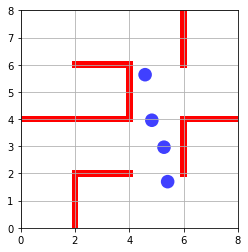

In [91]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in Trayectorias_exitosas[26]:
    ax.add_patch(Circle((v[0], v[1]), .25, facecolor='blue', alpha = 0.75))

plt.grid()
plt.show()

In [94]:
verticesPath = []

inicio = [0.52487734, 0.74404224]
goal = [5.80209241,4.4399534]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

    
while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 1:
        qnext = clf.predict(qt)
        qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
        verticesPath.append([qnext[0][0],qnext[0][1]])
       

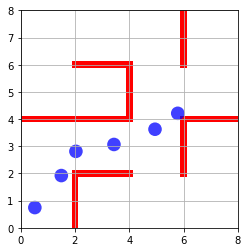

In [95]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), .25, facecolor='blue', alpha = 0.75))

plt.grid()
plt.show()

# Entrenamiento Red Neuronal TF Dropout

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .90)

In [25]:
import tensorflow as tf
import keras as keras
from keras.layers import PReLU
from keras import layers, losses, models
from keras.models import Model
import numpy as np

In [47]:
mlp = models.Sequential([
  layers.Dense(128, activation=PReLU()),
	layers.Dropout(0.25),
  layers.Dense(64),
	layers.Activation(activation=PReLU()),
	layers.Dropout(0.25),
  layers.Dense(32),
	layers.Dropout(0.25),
	layers.Activation(activation=PReLU()),
  layers.Dense(2),
	#layers.Activation(activation=PReLU()),
])

In [52]:
epochs = 4000
obs_name = 'obs1'
vicinity = 'v1'

models_path = 'C:/Users/jafet/Desktop/Semestre_6/Proyecto_Verano/models/'
save_file_path = models_path+'trained_model_'+obs_name +'_'+vicinity+'_'+'_samples_'+str(epochs)+'_epochs.h5'

# Save the best model only wrt validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# Loss and Optimizer
mlp.compile(#loss=tf.keras.losses.MeanAbsoluteError(),
      loss=tf.keras.losses.MeanSquaredError(),
			optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005)
	 		#optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005)
			#optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005)
			#,metrics=['accuracy']
			)


# Training
history = mlp.fit(x = X_train,
					y = y_train,
					validation_data=(X_test, y_test),
					batch_size=128,
					epochs=epochs,
					validation_split=0.05,
					verbose=2,
					callbacks=[model_checkpoint_callback]
)

Epoch 1/4000
92/92 - 1s - loss: 5.5851 - val_loss: 0.7642 - 1s/epoch - 14ms/step
Epoch 2/4000
92/92 - 0s - loss: 2.4110 - val_loss: 0.5580 - 306ms/epoch - 3ms/step
Epoch 3/4000
92/92 - 0s - loss: 1.8815 - val_loss: 0.5396 - 302ms/epoch - 3ms/step
Epoch 4/4000
92/92 - 0s - loss: 1.5809 - val_loss: 0.4072 - 303ms/epoch - 3ms/step
Epoch 5/4000
92/92 - 0s - loss: 1.3618 - val_loss: 0.5099 - 284ms/epoch - 3ms/step
Epoch 6/4000
92/92 - 0s - loss: 1.2675 - val_loss: 0.5400 - 269ms/epoch - 3ms/step
Epoch 7/4000
92/92 - 0s - loss: 1.1535 - val_loss: 0.4917 - 271ms/epoch - 3ms/step
Epoch 8/4000
92/92 - 0s - loss: 1.0845 - val_loss: 0.4460 - 274ms/epoch - 3ms/step
Epoch 9/4000
92/92 - 0s - loss: 1.0386 - val_loss: 0.4948 - 269ms/epoch - 3ms/step
Epoch 10/4000
92/92 - 0s - loss: 1.0046 - val_loss: 0.6167 - 281ms/epoch - 3ms/step
Epoch 11/4000
92/92 - 0s - loss: 0.9580 - val_loss: 0.4046 - 329ms/epoch - 4ms/step
Epoch 12/4000
92/92 - 0s - loss: 0.9642 - val_loss: 0.4789 - 289ms/epoch - 3ms/step
Epo

In [53]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)

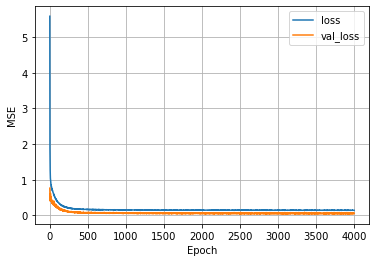

In [54]:
plot_loss(history)

# Pruebas Red Neuronal TF Dropout

In [70]:
model_path = 'C:/Users/jafet/Desktop/Semestre_6/Proyecto_Verano/models/trained_model_obs1_v1__samples_4000_epochs.h5'
mlp = keras.models.load_model(model_path)

In [72]:
Trayectorias_exitosas2 = []
Duraciones_exitosas2 = []
cnt = 0

max_iter = 30


for arreglo in arreglos_leidos:

    verticesPath = []

    inicio = [arreglo[0], arreglo[1]]
    goal = [arreglo[2], arreglo[3]]

    qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
    verticesPath.append([qt[0][0],qt[0][1]])

    iter = 0
    start = time.time()
    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= .75 and iter <= max_iter:
        qnext = mlp.predict(np.array(qt))
        qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
        verticesPath.append([qnext[0][0],qnext[0][1]])
        print(qnext)
        iter+= 1
    end = time.time()
    dur = end - start

    aux = 0
    for i in range(len(verticesPath)- 1):
        if collisionFree(verticesPath[i + 1][0], verticesPath[i + 1][1],verticesPath[i][0], verticesPath[i][1], .25) == False:
            break
        else:
            aux+=1
    
    if aux == len(verticesPath) -1:
        Trayectorias_exitosas2.append(verticesPath)
        Duraciones_exitosas2.append(dur)
        cnt+=1
    


    


1/1 [==============================] - 0s 32ms/step
[[1.4404469 1.9788797]]
1/1 [==============================] - 0s 28ms/step
[[2.0144503 2.4914885]]
1/1 [==============================] - 0s 27ms/step
[[3.0721636 2.974074 ]]
1/1 [==============================] - 0s 29ms/step
[[4.351243  3.4364095]]
1/1 [==============================] - 0s 38ms/step
[[5.0596027 4.100279 ]]
1/1 [==============================] - 0s 32ms/step
[[5.655971 4.626213]]
1/1 [==============================] - 0s 26ms/step
[[5.963877  1.1967745]]
1/1 [==============================] - 0s 29ms/step
[[5.20582  1.494479]]
1/1 [==============================] - 0s 29ms/step
[[4.8029656 1.5694661]]
1/1 [==============================] - 0s 35ms/step
[[4.6987696 1.6089094]]
1/1 [==============================] - 0s 31ms/step
[[4.669618  1.6208789]]
1/1 [==============================] - 0s 30ms/step
[[4.6612673 1.6243315]]
1/1 [==============================] - 0s 28ms/step
[[4.6588492 1.6252992]]
1/1 [===========

In [73]:
cnt

30

In [74]:
Trayectorias_exitosas2

[[[7.072083659293763, 1.4289125112207088],
  [5.963877, 1.1967745],
  [5.20582, 1.494479],
  [4.8029656, 1.5694661],
  [4.6987696, 1.6089094],
  [4.669618, 1.6208789],
  [4.6612673, 1.6243315],
  [4.6588492, 1.6252992],
  [4.658041, 1.6254454],
  [4.6578083, 1.6254761],
  [4.6577444, 1.625483],
  [4.657727, 1.6254847],
  [4.657722, 1.6254854],
  [4.657721, 1.6254857],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854],
  [4.6577206, 1.6254854]],
 [[5.869883818977771, 4.586905906708351],
  [5.162489, 5.7616596],
  [4.7071385, 6.252798],
  [4.4015675, 6.583352]],
 [[0.4197556437372297, 3.0993605301841995]

In [75]:
len(Trayectorias_exitosas2)

30

In [76]:
Duraciones_exitosas2

[2.7410800457000732,
 0.24219059944152832,
 0.5689783096313477,
 0.26599931716918945,
 0.5640072822570801,
 0.0,
 0.16700983047485352,
 0.2570018768310547,
 2.246887445449829,
 0.33499765396118164,
 0.6560118198394775,
 0.30698609352111816,
 0.121002197265625,
 0.0,
 2.0169947147369385,
 2.161432981491089,
 0.0,
 0.08301138877868652,
 2.212996006011963,
 0.21497797966003418,
 0.15100693702697754,
 0.32579994201660156,
 2.2697594165802,
 0.05900287628173828,
 0.15900421142578125,
 2.0450146198272705,
 0.24500012397766113,
 0.0,
 0.05199384689331055,
 0.3780064582824707]

## Tiempo y Promedio

In [77]:
Tiempo_TFD = np.array(Duraciones_exitosas2)
Mean_time_TFD = np.mean(Tiempo_TFD)
print("Promedio Tiempo TF Dropout -> ", Mean_time_TFD)

Promedio Tiempo TF Dropout ->  0.6948717991511028


## Costos y Promedio

In [78]:
Costos_TFD = []

for path in Trayectorias_exitosas2:

    costo = 0
    for i in range(len(path) - 1):
        costo += distancia_euclidiana(np.array(path[i]), np.array(path[i + 1]))

    Costos_TFD.append(costo)

In [79]:
Costos_TFD = np.array(Costos_TFD)
Mean_costos_TFD = np.mean(Costos_TFD)
print("Promedio Costos TFD -> ", Mean_costos_TFD)

Promedio Costos TFD ->  3.4011945724879173


## Desviaciones Estandares

In [80]:
print("Desviacion Estandar Costos TF -> ", np.std(Costos_TFD))
print("Desviacion Estandar Tiempos TF -> ", np.std(Tiempo_TFD))

Desviacion Estandar Costos TF ->  2.453601484099178
Desviacion Estandar Tiempos TF ->  0.8752334996108623


In [104]:
verticesPath = []
inicio = [0.52487734, 0.74404224]
goal = [5.80209241, 4.4399534]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 1:
    qnext = mlp.predict(np.array(qt))
    qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
    verticesPath.append([qnext[0][0],qnext[0][1]])
    print(qnext)

1/1 [==============================] - 0s 27ms/step
[[1.5675929 2.1295743]]
1/1 [==============================] - 0s 25ms/step
[[2.1329417 2.6261377]]
1/1 [==============================] - 0s 24ms/step
[[3.4085321 3.219283 ]]
1/1 [==============================] - 0s 22ms/step
[[4.4440374 3.7290711]]
1/1 [==============================] - 0s 22ms/step
[[5.1130486 4.145443 ]]


In [37]:
verticesPath = []
inicio = [7, 3]
goal = [3, 5]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 1:
    qnext = mlp.predict(np.array(qt))
    qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
    verticesPath.append([qnext[0][0],qnext[0][1]])
    print(qnext)

1/1 [==============================] - 0s 39ms/step
[[5.916217  1.6426992]]
1/1 [==============================] - 0s 29ms/step
[[5.5908694 1.7414882]]
1/1 [==============================] - 0s 29ms/step
[[5.1513395 3.0223174]]
1/1 [==============================] - 0s 31ms/step
[[4.946545  3.8040457]]
1/1 [==============================] - 0s 28ms/step
[[4.5972004 5.206834 ]]
1/1 [==============================] - 0s 27ms/step
[[4.453538 5.643563]]
1/1 [==============================] - 0s 27ms/step
[[4.38403  5.864397]]
1/1 [==============================] - 0s 27ms/step
[[4.2724705 5.782021 ]]
1/1 [==============================] - 0s 27ms/step
[[4.2236667 5.745566 ]]
1/1 [==============================] - 0s 32ms/step
[[4.2052956 5.73213  ]]
1/1 [==============================] - 0s 27ms/step
[[4.1991787 5.7282324]]
1/1 [==============================] - 0s 30ms/step
[[4.1972585 5.72713  ]]
1/1 [==============================] - 0s 30ms/step
[[4.1965823 5.7266355]]
1/1 [===========

KeyboardInterrupt: 

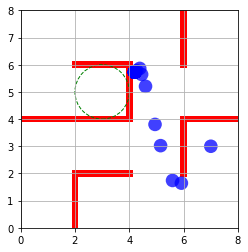

In [38]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), .25, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 1, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()

# Entrenamiento Red Neuronal TF 

In [60]:
mlp2 = models.Sequential([
  layers.Dense(128, activation=PReLU()),
  layers.Dense(64),
	layers.Activation(activation=PReLU()),
  layers.Dense(32),
	layers.Activation(activation=PReLU()),
  layers.Dense(2),
	#layers.Activation(activation=PReLU()),
])

In [61]:
epochs = 4000
obs_name = 'obs2'
vicinity = 'v2'

models_path = 'C:/Users/jafet/Desktop/Semestre_6/Proyecto_Verano/models/'
save_file_path = models_path+'trained_model_'+obs_name +'_'+vicinity+'_'+'_samples_'+str(epochs)+'_epochs.h5'

# Save the best model only wrt validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# Loss and Optimizer
mlp2.compile(#loss=tf.keras.losses.MeanAbsoluteError(),
      loss=tf.keras.losses.MeanSquaredError(),
			optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005)
	 		#optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005)
			#optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005)
			#,metrics=['accuracy']
			)


# Training
history = mlp2.fit(x = X_train,
					y = y_train,
					validation_data=(X_test, y_test),
					batch_size=128,
					epochs=epochs,
					validation_split=0.05,
					verbose=2,
					callbacks=[model_checkpoint_callback]
)

Epoch 1/4000
92/92 - 1s - loss: 3.2762 - val_loss: 0.4011 - 909ms/epoch - 10ms/step
Epoch 2/4000
92/92 - 0s - loss: 0.3398 - val_loss: 0.3007 - 247ms/epoch - 3ms/step
Epoch 3/4000
92/92 - 0s - loss: 0.2830 - val_loss: 0.2672 - 240ms/epoch - 3ms/step
Epoch 4/4000
92/92 - 0s - loss: 0.2564 - val_loss: 0.2529 - 250ms/epoch - 3ms/step
Epoch 5/4000
92/92 - 0s - loss: 0.2420 - val_loss: 0.2357 - 283ms/epoch - 3ms/step
Epoch 6/4000
92/92 - 0s - loss: 0.2302 - val_loss: 0.2282 - 264ms/epoch - 3ms/step
Epoch 7/4000
92/92 - 0s - loss: 0.2218 - val_loss: 0.2223 - 266ms/epoch - 3ms/step
Epoch 8/4000
92/92 - 0s - loss: 0.2155 - val_loss: 0.2135 - 259ms/epoch - 3ms/step
Epoch 9/4000
92/92 - 0s - loss: 0.2099 - val_loss: 0.2085 - 281ms/epoch - 3ms/step
Epoch 10/4000
92/92 - 0s - loss: 0.2048 - val_loss: 0.2076 - 262ms/epoch - 3ms/step
Epoch 11/4000
92/92 - 0s - loss: 0.2016 - val_loss: 0.2028 - 265ms/epoch - 3ms/step
Epoch 12/4000
92/92 - 0s - loss: 0.1982 - val_loss: 0.1983 - 270ms/epoch - 3ms/step


In [81]:
model_path = 'C:/Users/jafet/Desktop/Semestre_6/Proyecto_Verano/models/trained_model_obs2_v2__samples_4000_epochs.h5'
mlp2 = keras.models.load_model(model_path)

In [82]:
Trayectorias_exitosas3 = []
Duraciones_exitosas3 = []
cnt = 0

max_iter = 30


for arreglo in arreglos_leidos:

    verticesPath = []

    inicio = [arreglo[0], arreglo[1]]
    goal = [arreglo[2], arreglo[3]]

    qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
    verticesPath.append([qt[0][0],qt[0][1]])

    iter = 0
    start = time.time()
    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= .75 and iter <= max_iter:
        qnext = mlp2.predict(np.array(qt))
        qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
        verticesPath.append([qnext[0][0],qnext[0][1]])
        print(qnext)
        iter+= 1
    end = time.time()
    dur = end - start

    aux = 0
    for i in range(len(verticesPath)- 1):
        if collisionFree(verticesPath[i + 1][0], verticesPath[i + 1][1],verticesPath[i][0], verticesPath[i][1], .25) == False:
            break
        else:
            aux+=1
    
    if aux == len(verticesPath) -1:
        Trayectorias_exitosas3.append(verticesPath)
        Duraciones_exitosas3.append(dur)
        cnt+=1
    


    


1/1 [==============================] - 0s 194ms/step
[[1.8747876 2.3524332]]
1/1 [==============================] - 0s 47ms/step
[[2.9450967 2.8899589]]
1/1 [==============================] - 0s 49ms/step
[[4.1467605 3.5198238]]
1/1 [==============================] - 0s 44ms/step
[[5.3052464 3.9570272]]
1/1 [==============================] - 0s 51ms/step
[[7.182253  2.2403681]]
1/1 [==============================] - 0s 46ms/step
[[6.5207486 1.9466493]]
1/1 [==============================] - 0s 34ms/step
[[6.4222136 1.748803 ]]
1/1 [==============================] - 0s 38ms/step
[[6.366174  1.7325886]]
1/1 [==============================] - 0s 39ms/step
[[6.3084226 1.7015071]]
1/1 [==============================] - 0s 44ms/step
[[6.2464633 1.6803102]]
1/1 [==============================] - 0s 37ms/step
[[6.182054  1.6484116]]
1/1 [==============================] - 0s 44ms/step
[[6.101591  1.6286389]]
1/1 [==============================] - 0s 27ms/step
[[5.913966  1.6586668]]
1/1 [======

## Tiempo y Promedio

In [83]:
Tiempo_TF = np.array(Duraciones_exitosas3)
Mean_time_TF = np.mean(Tiempo_TF)
print("Promedio Tiempo TF  -> ", Mean_time_TF)

Promedio Tiempo TF  ->  0.4661446412404378


## Costos y Promedio

In [84]:
Costos_TF = []

for path in Trayectorias_exitosas3:

    costo = 0
    for i in range(len(path) - 1):
        costo += distancia_euclidiana(np.array(path[i]), np.array(path[i + 1]))

    Costos_TF.append(costo)

In [85]:
Costos_TF = np.array(Costos_TF)
Mean_costos_TF = np.mean(Costos_TF)
print("Promedio Costos TF -> ", Mean_costos_TF)

Promedio Costos TF ->  4.35340175610485


## Desviaciones Estandares

In [86]:
print("Desviacion Estandar Costos TF -> ", np.std(Costos_TF))
print("Desviacion Estandar Tiempos TF -> ", np.std(Tiempo_TF))

Desviacion Estandar Costos TF ->  3.123471370438155
Desviacion Estandar Tiempos TF ->  0.6144001649171913


In [87]:
cnt

36

In [74]:
verticesPath = []
inicio = [0.52487734, 0.74404224]
goal = [5.80209241, 4.4399534]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 1:
    qnext = mlp2.predict(np.array(qt))
    qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
    verticesPath.append([qnext[0][0],qnext[0][1]])
    print(qnext)

1/1 [==============================] - 0s 20ms/step


[[1.8975768 2.3865364]]
1/1 [==============================] - 0s 20ms/step
[[3.122864  2.8921764]]
1/1 [==============================] - 0s 21ms/step
[[4.577595  3.7332547]]
1/1 [==============================] - 0s 19ms/step
[[5.769523 4.238714]]


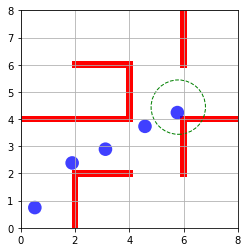

In [75]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), .25, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 1, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()